# <img src="https://uxwing.com/wp-content/themes/uxwing/download/business-professional-services/boy-services-support-icon.png" style="height: 40px"/> MLRun's Call Center Demo

## Notebook 1: Data Generation:

Welcome to Iguazio Internet company's call center. This demo showcases how to use GenAI to analyze calls, turning call center audio files of customers and agents into valuable data, all in one single workflow orchestrated by MLRun.

MLRun automates the entire workflow, auto-scales resources as needed, automatically distributes inference jobs to multiple workers, and automatically logs and parses values between the different workflow steps.

The demo demonstrates two usages of GenAI:
* **Unstructured Data Generation** &mdash; Generating audio data with ground truth metadata to evaluate the analysis.
* **Unstructured Data Analysis** &mdash; Turning audio calls into text and tabular features.

## Table of contents:

1. [Create the project](#create_the_project)
2. [Generate the call data](#generate_the_call_data)
3. [Calls analysis](#calls_analysis)
4. [View the data](#view_the_data)
5. [Future work](#future_work)

___
<a id="create_the_project"></a>
## 1. Create the project 

### 1.1 Install the requirements

This demo requires:
* [**MLRun**](https://www.mlrun.org/) &mdash; Orchestrate the demo's workflows.
* [**SQLAlchemy**](https://www.sqlalchemy.org/) &mdash; Manage the MySQL DB of calls, clients and agents.
* [**Vizro**](https://vizro.mckinsey.com/) &mdash; To view the call center DB and transcriptions, and to play the generated conversations.

In [1]:
# !pip install SQLAlchemy==2.0.31 pymysql dotenv

### 1.2 Setup
Please set the following configuration - choose compute device: CPU or GPU, choose the language of the calls, and whether to skip the calls generation workflow and use pre-generated data.

#### Setup in Iguazio Cluster

- This demo is limited to run with MLRun 1.9.x Python 3.11, with CPU, and run the pipeline with `engine = "remote"`.
- GPU is not supported at the moment.
- Need to setup a mysql database for the demo. sqlite is not supported now.
- Please set `run_with_gpu = False`, `engine = "remote"`
- .env include OPENAI_API_KEY, OPENAI_API_BASE

#### Setup in Platform McK

- GPU is not supported at the moment.
- sqlite is supported.
- Please set `run_with_gpu = False`, `engine = "remote"`
- .env include OPENAI_API_KEY, OPENAI_API_BASE, and S3_BUCKET_NAME

### 1.3 Fill the tokens and URL

> **⚠️ Important** Please fill the following variables in your `.env` file.

Tokens are required to run the demo end-to-end:
* [OpenAI ChatGPT](https://chat.openai.com/) &mdash; To generate conversations, two tokens are required:
  * `OPENAI_API_KEY`
  * `OPENAI_API_BASE`

For Platform Mck, a s3 bucket name needs to be in the `.env`
* [S3 Bucket]() &mdash; 
  * `S3_BUCKET_NAME`

In [2]:
# True = run with GPU, False = run with CPU
run_with_gpu = False
language = "en" # The languages of the calls, es - Spanish, en - English
skip_calls_generation = False

In [3]:
import dotenv
import os
import sys
import mlrun
dotenv_file = ".env"
sys.path.insert(0, os.path.abspath("./"))

dotenv.load_dotenv(dotenv_file)

True

In [4]:
assert not run_with_gpu
assert os.environ["OPENAI_API_BASE"]
assert os.environ["OPENAI_API_KEY"]

### 1.3 Set up the project

The MLRun project is created by running the function [`mlrun.get_or_create_project`](https://docs.mlrun.org/en/latest/api/mlrun.projects.html#mlrun.projects.get_or_create_project). This creates the project (or loads it if previously created) and sets it up automatically according to the [project_setup.py](./project_setup.py) file located in this repo. 

The project_setup.py file sets the functions according to the following default `parameters`. You can adjust them as relevant:

* `source : str` &mdash; The git repo source of the project to clone when each function is running.
* `default_image : str` &mdash; The default image to use for running the workflow's functions. For the sake of simplicity, the demo uses the same image for all the functions.
* `gpus: int` &mdash; The number of GPUs to use when running the demo. 0 means CPU.
* `node_selector: Dict[str, str]` &mdash; The node selector to use when running the demo (optional).
* `node_name: str` &mdash; The node name to run the demo on (optional).

> Note: Multiple GPUs (`gpus` > 1) automatically deploy [OpenMPI](https://www.open-mpi.org/) jobs for **better performance and GPU utilization**.

There are not many functions under the source directory. That's because most of the code in this project is imported from [**MLRun's Function hub**](https://www.mlrun.org/hub/) &mdash; a collection of reusable functions and assets that are optimized and tested to simplify and accelerate the move to production!

*Please note that you will need to set the `"build_image": True` once to build the default image for the project. After you successfully built the image, set the `"build_image": False"` to continue.*

In [5]:
project_name="call-center-demo"
project = mlrun.get_or_create_project(
    name=project_name,
    user_project=False,
    allow_cross_project=True,
    parameters={
        "build_image": False,
        "source": "git://github.com/xsqian/demo-call-center.git#main",
        "gpus": 1 if run_with_gpu else 0,
        "use_sqlite": True,
        "default_image": f'.mlrun-project-image-{project_name}',
        "skip_calls_generation": False
    },
)

default image from the get_param: .mlrun-project-image-call-center-demo
✓ File exists
Project Source: git://github.com/xsqian/demo-call-center.git#main
set default image to : .mlrun-project-image-call-center-demo
set wotkflow with image to: .mlrun-project-image-call-center-demo
set wotkflow with image to: .mlrun-project-image-call-center-demo
> 2026-01-13 00:14:53,852 [info] Project loaded successfully: {"project_name":"call-center-demo"}


___
<a id="generate_the_call_data"></a>
## 2. Generate the call data

> Note: This entire workflow can be skipped if you want to use data that is  already generated and  available in this demo. See the [next cell](#skip_and_import_local_data) for more details.

The data generation workflow comprises six steps. If you want to skip the agents and clients data generation and just generate calls using the existing agents and clients, then pass `generate_clients_and_agents = False`. You can see each function's docstring and code by clicking the function name in the following list:

1. (Skippable) [**Agents & Clients Data Generator**](https://github.com/mlrun/functions/blob/master/structured_data_generator)- ***Hub Function*** &mdash; Use OpenAI's ChatGPT to generate the metadata for the call center's agents and clients. The data include fields like first name, last name, phone number, etc. All the agents and clients steps run in parallel.
2. (Skippable) [**Insert Agents & Clients Data to DB**](.src/calls_analysis/data_management.py) &mdash; Insert the generated agents and clients data into the MySQL database.
3. [**Get Agents & Clients from DB**](.src/calls_analysis/data_management.py) &mdash; Get the call center data from the database, before passing it in the next step.
4. [**Conversation Generation**](./src/calls_generation/conversations_generator.py) &mdash; Here, OpenAI's ChatGPT is used to generate the conversations for the demo. We randomize prompts and keep their values for ground truths to evaluate the analysis later on.
5. [**Text to Audio**](https://github.com/mlrun/functions/blob/master/text_to_audio_generator) &mdash; ***Hub Function***: Using [OpenAI's TTS](https://platform.openai.com/docs/guides/text-to-speech), we generate audio files from the conversations that were produced by the text files.
6. [**Batch Creation**](./src/calls_generation/conversations_generator.py) &mdash; The last step is to wrap all of the generated data to an input batch that is ready for the analysis workflow!

After this workflow, the database is filled with data in the following structure:
* **Client Table**
  | Client ID | First Name | Last Name | Phone Number | Email              | Client City | Latitude | Longitude | Calls |
  | :-------- | :--------- | :-------- | :----------- | :----------------- | :---------- | :------ | :-------- | :----- |
  | 123456    | John       | Doe       | 123456789    | jondoe@example.com | Austin, TX  | 30.2672  | -97.7431  | []    |

* **Agent Table**
  | Agent ID  | First Name | Last Name | Calls |
  | :-------- | :--------- | :---------| :---- |
  |AG123      | John       |Doe        |[]     |


After create the tables, you can run the workflow to generate the necessary artifacts for the analysis workflow in notebook 2

In [6]:
from src.calls_analysis.db_management import create_tables
create_tables()

Tables created!


### 2.1. Run the workflow

Run the [described workflow](./src/workflows/calls_generation.py) by calling the project's method [`project.run`](https://docs.mlrun.org/en/latest/api/mlrun.projects.html#mlrun.projects.MlrunProject.run).

The following parameters are passed to the function as workflow `arguments`. Set them as relevant. You can choose the `amount` of calls you wish to generate, the models to use, and configure the metadata as you wish:

* `amount: int` &mdash; The number of samples to generate.
* `generation_model: str` &mdash; Which model from Open AI to use for data generation.
* `tts_model: str` &mdash; Which model to use for the text-to-speech conversion.
* `language: str` &mdash; The language to generate data in (this sample uses Spanish).
* `available_voices: List[str]` &mdash; What voices pool to choose from.
* `min_time: int` &mdash; Minimum duration of the generated calls.
* `max_time: int` &mdash; Maximum duration of the generated calls.
* `from_date: str` &mdash; Starting date for the calls (metadata of the call).
* `to_date: str` &mdash; Latest date for the calls (metadata of the call).
* `from_time: str` &mdash; Starting time for the calls (metadata of the call).
* `to_time: str` &mdash; Last time for the calls (time the call center closes). (metadata of the call).
* `num_clients: int` &mdash; Number of clients to generate.
* `num_agents: int` &mdash; Number of agents to generate.
* `generate_clients_and_agents: bool` &mdash; Skip the clients and agents generation (only generate new calls with the existing data).

In [7]:
project.spec.params['build_image']=False
project.save()

> 2026-01-13 00:14:54,201 [info] Submitting remote workflow: {"project_name":"call-center-demo","schedule":null,"workflow_engine":"kfp"}


> 2026-01-13 00:15:04,979 [info] Started run workflow call-center-demo-calls-generation with run id = '5e93bdc2-415f-4033-9d1f-3e2d7416cc56' by remote engine
> 2026-01-13 00:15:04,979 [info] Waiting for pipeline run completion: {"project":"call-center-demo","run_id":"5e93bdc2-415f-4033-9d1f-3e2d7416cc56"}


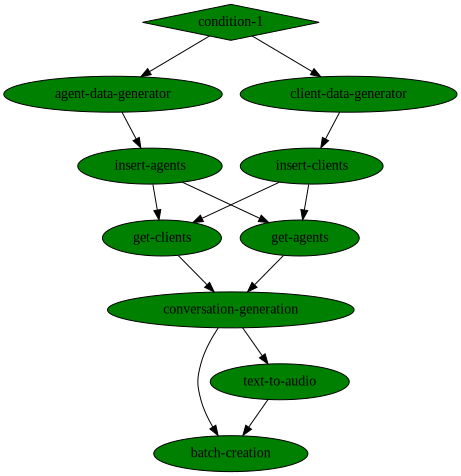

uid,start,end,state,kind,name,parameters,results
...128d1986,Jan 13 00:24:24,2026-01-13 00:24:25.849256+00:00,completed,run,batch-creation,,
...70513699,Jan 13 00:21:04,2026-01-13 00:23:30.584162+00:00,completed,run,text-to-audio,"speakers={'Agent': 0, 'Client': 1}available_voices=['alloy', 'echo', 'fable', 'onyx', 'nova', 'shimmer']model=tts-1speed=1",
...e813ba04,Jan 13 00:18:43,2026-01-13 00:20:02.979644+00:00,completed,run,conversation-generation,amount=5model_name=gpt-4language=enmin_time=2max_time=5from_date=08.15.2024to_date=08.14.2025from_time=09:00to_time=17:00,
...38aebd11,Jan 13 00:17:45,2026-01-13 00:17:45.749163+00:00,completed,run,get-agents,,
...2c9b84fd,Jan 13 00:17:45,2026-01-13 00:17:45.639929+00:00,completed,run,get-clients,,
...02d3757f,Jan 13 00:16:41,2026-01-13 00:16:42.551966+00:00,completed,run,insert-agents,,
...c407e6bf,Jan 13 00:16:41,2026-01-13 00:16:42.469998+00:00,completed,run,insert-clients,,
...67e6b8da,Jan 13 00:15:43,2026-01-13 00:15:51.477563+00:00,completed,run,client-data-generator,"amount=2model_name=gpt-4language=enfields=['first_name: in en, no special characters', 'last_name: in en, no special characters', 'phone_number', 'email', 'client_id: no leading zeros, at least 8 digits long, only numbers, this is a primay key field for the database, avoid duplicates as much as possible', 'client_city: Enter city, state in the US (e.g., Austin, TX), Not only Texas', 'latitude: That correspond to the city', 'longitude: That correspond to the city']",
...05119fa2,Jan 13 00:15:43,2026-01-13 00:15:47.653125+00:00,completed,run,agent-data-generator,"amount=2model_name=gpt-4language=enfields=['first_name: in en, no special characters', 'last_name: in en, no special characters', 'agent_id: no leading zeros, at least 8 digits long, only numbers, this is a primay key field for the database, avoid duplicates as much as possible']",


In [8]:
if not skip_calls_generation:
    calls_generation_workflow = project.run(
        name="calls-generation",
        arguments={
            "amount": 5,
            "num_clients": 2,
            "num_agents": 2,
            "generation_model": "gpt-4",
            "tts_model": "tts-1",
            "language":  language,
            "available_voices": [
                "alloy", "echo", "fable", "onyx", "nova", "shimmer"
            ],
            "min_time": 2,
            "max_time": 5,
            "from_date": "08.15.2024",
            "to_date": "08.14.2025",
            "from_time": "09:00",
            "to_time": "17:00",
            "generate_clients_and_agents": True,
        },
        watch=False,
        dirty=True,
        timeout=60 * 240,
        engine="remote"
    )

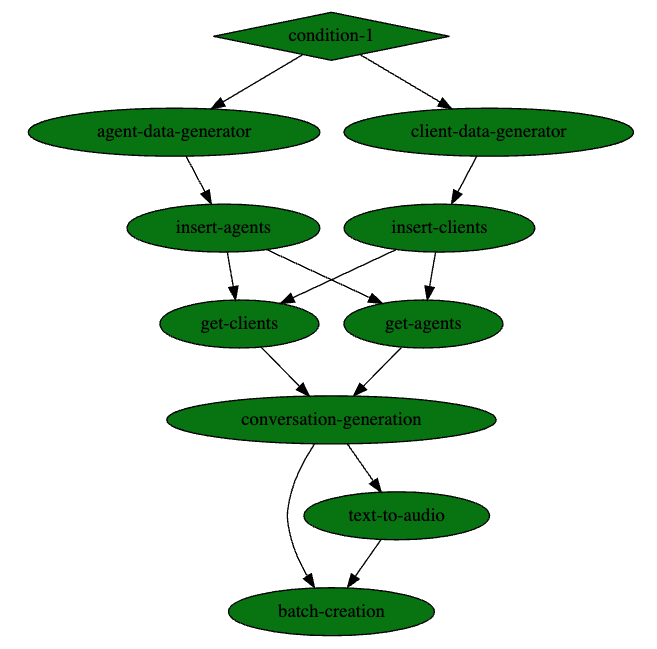